In [1]:
using LinearAlgebra
using Plots
using Statistics
using DataFrames
using Printf
using CSV

In [2]:
train_df = DataFrame(CSV.File("train.csv"));
first(train_df, 5)

┌ Warning: thread = 1 warning: only found 1 / 2 columns around data row: 214. Filling remaining columns with `missing`
└ @ CSV /home/hiraki/.julia/packages/CSV/owrEo/src/file.jl:623


,x,y
,Float64,Float64?
1,24.0,21.5495
2,50.0,47.4645
3,15.0,17.2187
4,38.0,36.5864
5,87.0,87.289


In [3]:
describe(train_df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,Type
1,x,54.9859,0.0,49.0,3530.16,0,Float64
2,y,49.9399,-3.83998,48.973,108.872,1,"Union{Missing, Float64}"


In [4]:
train_df = dropmissing(train_df)
describe(train_df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,x,50.0143,0.0,49.0,100.0,0,Float64
2,y,49.9399,-3.83998,48.973,108.872,0,Float64


In [5]:
X_train = train_df[:, :x];
Y_train = train_df[:, :y];
m = size(X_train, 1);
println("Shape of X_train:", size(X_train));
println("Shape of Y_train:", size(Y_train));

Shape of X_train:(699,)
Shape of Y_train:(699,)


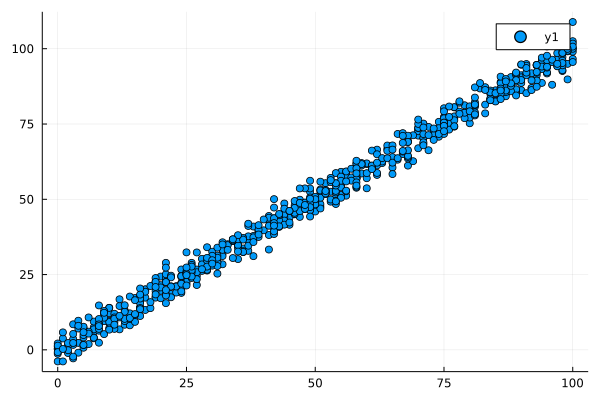

In [6]:
scatter(X_train, Y_train)

$$
\newcommand{\b}[1]{\mathbf{#1}}
\newcommand{\XX}{\mathbf X}
\newcommand{\xx}{\mathbf x}
\newcommand{\YY}{\mathbf Y}
\newcommand{\yy}{\mathbf y}
\newcommand{\ww}{\mathbf w}
\newcommand{\bb}{\mathbf b}
\newcommand{\powi}{^{(i)}}
$$

# Linear regression model
Prediction:
$$
\b x \in (f, 1) \\ 
\b w \in (f, 1) \\
\bb \in (1, 1) \ \text{(broadcasts to \( (m, 1) \))} \\
\hat{y} = \ww^T \xx + \bb \in (1, 1) \\ 
\hat{\YY} = \XX\ww + \bb \in (m, 1) \\
$$
Where 
$$
\XX = \begin{pmatrix}
    - \xx^{(1)T} - \\
    - \xx^{(2)T} - \\
    - \xx^{(3)T} - \\
    \vdots \\ 
    - \xx^{(m)T} - \\
\end{pmatrix} \in (m, f)
$$

Loss function:
$$
L = \frac{1}{2m} \sum_{i=0}^{m} (\ww^T\xx\powi + b - y\powi)^2 
  = \frac{1}{2m} (\XX\ww + \bb - \YY)^2 \\
\Rightarrow \frac{dL}{d\ww} = \frac{1}{m} \sum^{m}_{i=0} (\ww^T\xx\powi + b - y\powi) \cdot \xx
 = \frac{1}{m} \XX^T (\XX\ww + \bb - \YY) \in (f, 1) \\
\frac{dL}{d\bb} = \frac{1}{m} \sum^{m}_{i=0} (\ww^T\xx\powi + b - y\powi)
 = sum\left( \frac{1}{m} (\XX\ww + \bb - \YY) \right) = sum\left( \frac{1}{m} (\hat{\YY} - \YY) \right) \in (1, 1)
$$

In [7]:
function random_init(n_features)
    return rand(n_features, 1);
end

random_init (generic function with 1 method)

In [8]:
function cost_function(X, Y, parameters)
    w = parameters["w"];
    b = parameters["b"];
    
    cost = 1/(2*m) * sum((X*w .+ b - Y).^2);
    dw = 1/m * X' * (X*w .+ b - Y);
    db = 1/m * sum(X*w .+ b - Y);
    
    grad = Dict("dw" => dw, "db" => db);
    return cost, grad;
end

cost_function (generic function with 1 method)

In [9]:
function gradient_checking(X, Y)
    n_features = size(X, 2);
    w_check = random_init(n_features);
    b_check = rand();
    parameters = Dict("w" => w_check, "b" => b_check);
    
    cost, grad = cost_function(X, Y, parameters);
    dw = grad["dw"];
    db = grad["db"];
    
    epsilon = 1e-5;
    dw_approx = Float64[];
    for i = 1:n_features
        epsilon_vector = zeros(n_features);
        epsilon_vector[i] = epsilon;
        
        params_w_plus = Dict("w" => w_check + epsilon_vector, "b" => b_check);
        params_w_minus = Dict("w" => w_check - epsilon_vector, "b" => b_check);
        
        cost_w_plus, _ = cost_function(X, Y, params_w_plus);
        cost_w_minus, _ = cost_function(X, Y, params_w_minus);
        
        dw_approx_i = (cost_w_plus - cost_w_minus) / (2*epsilon);
        push!(dw_approx, dw_approx_i);
    end
    
    params_b_minus = Dict("w" => w_check, "b" => b_check - epsilon);
    params_b_plus  = Dict("w" => w_check, "b" => b_check + epsilon);
    
    cost_b_plus, _ = cost_function(X, Y, params_b_plus);
    cost_b_minus, _ = cost_function(X, Y, params_b_minus);
    
    db_approx = (cost_b_plus - cost_b_minus) / (2*epsilon);
        
    println("dw = ", dw);
    println("dw_approx = ", dw_approx);
    println("db = ", db);
    println("db_approx = ", db_approx);
end

gradient_checking (generic function with 1 method)

In [10]:
function gradient_descent(X, Y, params, cost_func, lr=0.01, max_iters=1000)
    w = copy(params["w"]);
    b = copy(params["b"]);
    
    costs = [];
    for i = 1:max_iters
        cost, grad = cost_func(X, Y, params);
        
        dw = grad["dw"];
        db = grad["db"];
        
        w = w - lr .* dw;
        b = b - lr * db;
        params = Dict("w" => w, "b" => b);
        
        push!(costs, cost);
        print("\rIter ", i, "/", max_iters, ": cost = ", cost, "; dw = ", grad["dw"], "; db = ", grad["db"]);
    end;
    
    return Dict("w" => w, "b" => b), costs;
end

gradient_descent (generic function with 3 methods)

In [11]:
gradient_checking(X_train, Y_train)

dw = [-2448.9497717533195]
dw_approx = [-2448.9497717695485]
db = -36.554764276860716
db_approx = -36.554764284346675


In [12]:
function predict(X, parameters)
    w = parameters["w"];
    b = parameters["b"];
    return X*w .+ b;
end

predict (generic function with 1 method)

In [13]:
function fit(X, Y, lr=0.01, max_iters=1000)
    n_features = size(X, 2);
    w = random_init(n_features);
    b = rand();
    
    params = Dict("w" => w, "b" => b);
    
    learned_params, costs = gradient_descent(X, Y, params, cost_function, lr, max_iters);
    
    return learned_params, costs;
end;

Iter 100/100: cost = 4.011897081503895; dw = [-0.0029628472404992223]; db = 0.19776367692917882

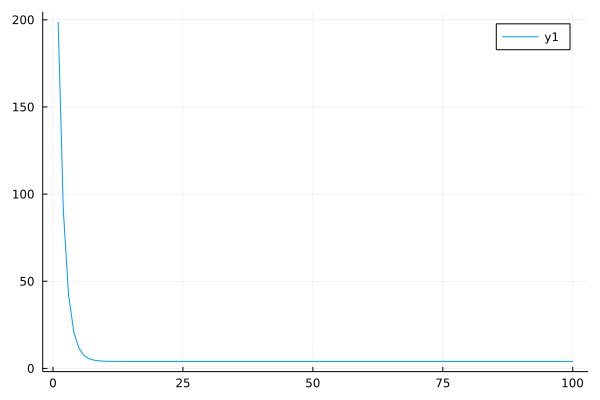

In [14]:
lr=1e-4;
max_iters=100;
learned_params, costs = fit(X_train, Y_train, lr, max_iters);
plot(1:max_iters, costs)

In [15]:
# Draw regresison line 
x_min = minimum(X_train);
x_max = maximum(X_train);
plot_x_range = x_min:x_max;

w = learned_params["w"][1, 1];
b = learned_params["b"];

y_reg = plot_x_range .* w .+ b;

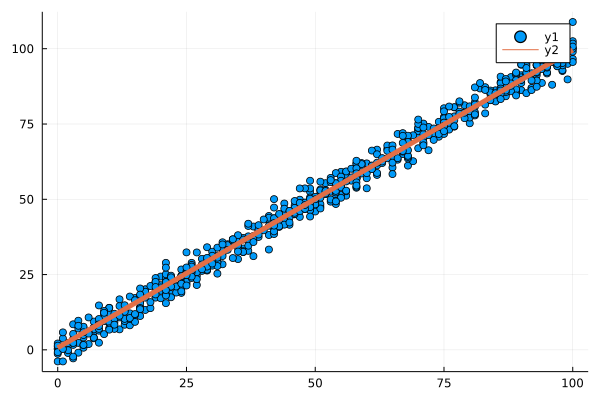

In [16]:
p  = scatter(X_train, Y_train);
plot!(p, plot_x_range, y_reg, lw=5)